## Project Predictive Analytics: New York City Taxi Ride Duration Prediction

## **Marks: 40**
---------------

## **Context**
---------------

New York City taxi rides form the core of the traffic in the city of New York. The many rides taken every day by New Yorkers in the busy city can give us a great idea of traffic times, road blockages, and so on.

A typical taxi company faces a common problem of efficiently assigning the cabs to passengers so that the service is hassle-free. One of the main issues is predicting the duration of the current ride so it can predict when the cab will be free for the next trip.

Here, the data set contains various pointers regarding the taxi trips and their duration in New York City. 

We will apply an array of techniques to get insights into the data and determine how different variables are dependent on the Trip Duration.

-----------------
## **Objective**
-----------------

- To Build a predictive model, for predicting the duration for the taxi ride. 
- Use Automated feature engineering to create new features

-----------------
## **Dataset**
-----------------

The ``trips`` table has the following fields
* ``id`` which uniquely identifies the trip
* ``vendor_id`` is the taxi cab company - in our case study we have data from three different cab companies
* ``pickup_datetime`` the time stamp for pickup
* ``dropoff_datetime`` the time stamp for drop-off
* ``passenger_count`` the number of passengers for the trip
* ``trip_distance`` total distance of the trip in miles 
* ``pickup_longitude`` the longitude for pickup
* ``pickup_latitude`` the latitude for pickup
* ``dropoff_longitude``the longitude of dropoff 
* ``dropoff_latitude`` the latitude of dropoff
* ``payment_type`` a numeric code signifying how the passenger paid for the trip. 
  - 1= Credit card
  - 2= Cash 3= No charge
  - 4= Dispute
  - 5= Unknown
  - 6= Voided
* ``trip_duration`` this is the duration (in seconds) we would like to predict using other fields 
* ``pickup_neighborhood`` a one or two letter id of the neighborhood where the trip started
* ``dropoff_neighborhood`` a one or two letter id of the neighborhood where the trip ended



### We will do the following steps:
  * Install the dependencies
  * Load the data as a pandas dataframe
  * Perform EDA on the dataset
  * Build features with Deep Feature Synthesis using the [featuretools](https://featuretools.com) package. We will start with simple features and incrementally improve the feature definitions while examining the accuracy of the system.

#### Uncomment the code given below, and run the line of code to install featuretools library

In [1]:
# Uncomment the code given below, and run the line of code to install featuretools library

# !pip install featuretools==0.27.0

### Note: If !pip install featuretools doesn't work, please install using the anaconda prompt by typing the following command in anaconda prompt
      conda install -c conda-forge featuretools==0.27.0

### Importing libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Feataurestools for feature engineering
import featuretools as ft

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Importing gradient boosting regressor, to make prediction
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

#importing primitives
from featuretools.primitives import (Minute, Hour, Day, Month,
                                     Weekday, IsWeekend, Count, Sum, Mean, Median, Std, Min, Max)

print(ft.__version__)
%load_ext autoreload
%autoreload 2

0.27.0


In [3]:
# set global random seed
np.random.seed(40)

# To load the dataset
def load_nyc_taxi_data():
    trips = pd.read_csv('./data/trips.csv',
                        parse_dates=["pickup_datetime","dropoff_datetime"],
                        dtype={'vendor_id':"category",'passenger_count':'int64'},
                        encoding='utf-8')
    trips["payment_type"] = trips["payment_type"].apply(str)
    trips = trips.dropna(axis=0, how='any', subset=['trip_duration'])

    pickup_neighborhoods = pd.read_csv("./data/pickup_neighborhoods.csv", encoding='utf-8')
    dropoff_neighborhoods = pd.read_csv("./data/dropoff_neighborhoods.csv", encoding='utf-8')

    return trips, pickup_neighborhoods, dropoff_neighborhoods

### To preview first five rows. 
def preview(df, n=5):
    """return n rows that have fewest number of nulls"""
    order = df.isnull().sum(axis=1).sort_values().head(n).index
    return df.loc[order]



#to compute features using automated feature engineering. 
def compute_features(features, cutoff_time):
    # shuffle so we don't see encoded features in the front or backs

    np.random.shuffle(features)
    feature_matrix = ft.calculate_feature_matrix(features,
                                                 cutoff_time=cutoff_time,
                                                 approximate='36d',
                                                 verbose=True)
    print("Finishing computing...")
    feature_matrix, features = ft.encode_features(feature_matrix, features,
                                                  to_encode=["pickup_neighborhood", "dropoff_neighborhood"],
                                                  include_unknown=False)
    return feature_matrix


#to generate train and test dataset
def get_train_test_fm(feature_matrix, percentage):
    nrows = feature_matrix.shape[0]
    head = int(nrows * percentage)
    tail = nrows-head
    X_train = feature_matrix.head(head)
    y_train = X_train['trip_duration']
    X_train = X_train.drop(['trip_duration'], axis=1)
    imp = SimpleImputer()
    X_train = imp.fit_transform(X_train)
    X_test = feature_matrix.tail(tail)
    y_test = X_test['trip_duration']
    X_test = X_test.drop(['trip_duration'], axis=1)
    X_test = imp.transform(X_test)

    return (X_train, y_train, X_test,y_test)



#to see the feature importance of variables in the final model
def feature_importances(model, feature_names, n=5):
    importances = model.feature_importances_
    zipped = sorted(zip(feature_names, importances), key=lambda x: -x[1])
    for i, f in enumerate(zipped[:n]):
        print("%d: Feature: %s, %.3f" % (i+1, f[0], f[1]))

### Load the Datasets

In [4]:
trips, pickup_neighborhoods, dropoff_neighborhoods = load_nyc_taxi_data()
preview(trips, 10)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
0,0,2,2016-01-01 00:00:19,2016-01-01 00:06:31,3,1.32,-73.961258,40.796200,-73.950050,40.787312,2,372.0,AH,C
649598,679634,1,2016-04-30 11:45:59,2016-04-30 11:47:47,1,0.50,-73.994919,40.755226,-74.000351,40.747917,1,108.0,D,AG
649599,679635,2,2016-04-30 11:46:04,2016-04-30 11:47:41,2,0.33,-73.978935,40.777172,-73.981888,40.773136,2,97.0,AV,AV
649600,679636,2,2016-04-30 11:46:39,2016-04-30 11:58:02,1,1.78,-73.998207,40.745201,-73.990265,40.729023,2,683.0,AP,H
649601,679637,2,2016-04-30 11:46:44,2016-04-30 11:55:42,1,1.40,-73.987129,40.739429,-74.007370,40.743511,2,538.0,R,Q
649602,679638,2,2016-04-30 11:47:30,2016-04-30 11:54:00,1,1.12,-73.942375,40.790768,-73.952095,40.777145,2,390.0,J,AM
649603,679639,1,2016-04-30 11:47:38,2016-04-30 11:57:22,2,1.90,-73.960800,40.769920,-73.978966,40.785698,1,584.0,K,I
649604,679640,1,2016-04-30 11:47:49,2016-04-30 12:01:05,1,4.30,-74.013885,40.709515,-73.987213,40.722343,2,796.0,AU,AC
649605,679641,1,2016-04-30 11:48:17,2016-04-30 12:01:02,1,2.90,-73.975426,40.757584,-73.999016,40.722027,1,765.0,A,X
649606,679642,1,2016-04-30 11:49:44,2016-04-30 12:00:03,1,1.30,-73.989815,40.750454,-74.000473,40.762352,2,619.0,D,P


### Display first five rows

In [5]:
trips.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
0,0,2,2016-01-01 00:00:19,2016-01-01 00:06:31,3,1.32,-73.961258,40.796200,-73.950050,40.787312,2,372.0,AH,C
1,1,2,2016-01-01 00:01:45,2016-01-01 00:27:38,1,13.70,-73.956169,40.707756,-73.939949,40.839558,1,1553.0,Z,S
2,2,1,2016-01-01 00:01:47,2016-01-01 00:21:51,2,5.30,-73.993103,40.752632,-73.953903,40.816540,2,1204.0,D,AL
3,3,2,2016-01-01 00:01:48,2016-01-01 00:16:06,1,7.19,-73.983009,40.731419,-73.930969,40.808460,2,858.0,AT,J
4,4,1,2016-01-01 00:02:49,2016-01-01 00:20:45,2,2.90,-74.004631,40.747234,-73.976395,40.777237,1,1076.0,AG,AV


### Display info of the dataset

In [6]:
#checking the info of the dataset
trips.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 974409 entries, 0 to 974408
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   id                    974409 non-null  int64         
 1   vendor_id             974409 non-null  category      
 2   pickup_datetime       974409 non-null  datetime64[ns]
 3   dropoff_datetime      974409 non-null  datetime64[ns]
 4   passenger_count       974409 non-null  int64         
 5   trip_distance         974409 non-null  float64       
 6   pickup_longitude      974409 non-null  float64       
 7   pickup_latitude       974409 non-null  float64       
 8   dropoff_longitude     974409 non-null  float64       
 9   dropoff_latitude      974409 non-null  float64       
 10  payment_type          974409 non-null  object        
 11  trip_duration         974409 non-null  float64       
 12  pickup_neighborhood   974409 non-null  object        
 13 

- There are 974409 non null values in the dataset

### Check the number of unique values in the dataset.

In [7]:
# Check the uniques values in each columns
trips.nunique()

id                      974409
vendor_id                    2
pickup_datetime         939015
dropoff_datetime        938873
passenger_count              8
trip_distance             2503
pickup_longitude         20222
pickup_latitude          40692
dropoff_longitude        26127
dropoff_latitude         50077
payment_type                 4
trip_duration             3607
pickup_neighborhood         49
dropoff_neighborhood        49
dtype: int64

**Write your answers here:_____**
- vendor_id has only 2 unique values, implies there are only 2 major taxi vendors in the dataset. 
- Passenger count has 8 unique values and payment type have 4. 
- There are 49 neighborhood in the dataset, from where either a pickup or dropoff is happening. 

### Question 1 : Check summary statistics of the dataset (1 Mark)

In [8]:
#chekcing the descriptive stats of the data


round(trips.describe().T, 3)

,count,mean,std,min,25%,50%,75%,max
id,974409.0,509622.259,294491.647,0.00,254521.000,509310.000,764743.000,1020002.000
passenger_count,974409.0,1.664,1.315,0.00,1.000,1.000,2.000,9.000
trip_distance,974409.0,2.734,3.307,0.00,1.000,1.640,2.990,502.800
pickup_longitude,974409.0,-73.973,0.036,-74.03,-73.991,-73.981,-73.967,-73.771
pickup_latitude,974409.0,40.752,0.027,40.63,40.740,40.755,40.769,40.850
dropoff_longitude,974409.0,-73.973,0.031,-74.03,-73.990,-73.979,-73.963,-73.770
dropoff_latitude,974409.0,40.753,0.029,40.63,40.739,40.756,40.770,40.850
trip_duration,974409.0,797.703,576.802,0.00,389.000,646.000,1040.000,3606.000


**Write your answers here:**
- The median and 75% of the `passenger_count` is 1 and  2 respectively. 
- Average trip_distance is 2.73km, with a maximum value of 502km and Minimum for trip distance is 0.
- Average trip_duration is 797 sec. 

#### Checking for the rows for which trip_distance is 0

In [9]:
#Chekcing the rows where trip distance is 0
trips[trips['trip_distance']==0]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
852,880,1,2016-01-01 02:15:56,2016-01-01 02:16:17,1,0.0,-74.002586,40.750298,-74.002861,40.750446,2,21.0,AG,AG
1079,1116,1,2016-01-01 03:01:10,2016-01-01 03:03:26,1,0.0,-73.987831,40.728558,-73.988747,40.727280,3,136.0,H,H
1408,1455,2,2016-01-01 04:09:43,2016-01-01 04:10:48,1,0.0,-73.985893,40.763649,-73.985741,40.763672,2,65.0,AR,AR
1440,1488,1,2016-01-01 04:16:54,2016-01-01 04:16:57,1,0.0,-74.014198,40.709988,-74.014198,40.709988,3,3.0,AU,AU
1510,1558,1,2016-01-01 04:36:03,2016-01-01 04:36:16,1,0.0,-73.952507,40.817329,-73.952499,40.817322,2,13.0,AL,AL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
972967,1018490,1,2016-06-30 19:09:44,2016-06-30 19:22:21,1,0.0,-73.945480,40.751400,-73.945496,40.751549,2,757.0,AN,AN
973384,1018928,2,2016-06-30 20:35:08,2016-06-30 20:35:10,1,0.0,-73.983864,40.693813,-73.983910,40.693817,1,2.0,AS,AS
973555,1019105,2,2016-06-30 21:13:50,2016-06-30 21:14:05,1,0.0,-74.008789,40.708740,-74.008659,40.708858,1,15.0,AU,AU
973607,1019159,2,2016-06-30 21:24:23,2016-06-30 21:37:40,1,0.0,-73.974510,40.778297,-73.977272,40.754047,1,797.0,I,AD


**Write your answers here:_____**
- We can observe that, where trip distance is 0 trip duration is not 0, hence we can replace those values. 
- There are 3807 such rows

#### Replacing the 0 values with median of the trip distance

In [10]:
trips['trip_distance']=trips['trip_distance'].replace(0,trips['trip_distance'].median())

In [11]:
trips[trips['trip_distance']==0].count()

id                      0
vendor_id               0
pickup_datetime         0
dropoff_datetime        0
passenger_count         0
trip_distance           0
pickup_longitude        0
pickup_latitude         0
dropoff_longitude       0
dropoff_latitude        0
payment_type            0
trip_duration           0
pickup_neighborhood     0
dropoff_neighborhood    0
dtype: int64

#### Checking for the rows for which trip_duration is 0

In [12]:
trips[trips['trip_duration']==0].head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
44446,46325,1,2016-01-10 00:48:55,2016-01-10 00:48:55,1,1.20,-73.968842,40.766972,-73.968842,40.766972,3,0.0,AK,AK
121544,126869,2,2016-01-26 00:07:47,2016-01-26 00:07:47,6,4.35,-73.986694,40.739815,-73.956139,40.732872,1,0.0,R,Z
142202,148598,1,2016-01-30 00:00:29,2016-01-30 00:00:29,1,1.64,-73.989578,40.743877,-73.989578,40.743877,2,0.0,AO,AO
172653,180414,1,2016-02-04 19:23:45,2016-02-04 19:23:45,1,0.40,-73.990868,40.751106,-73.990868,40.751106,2,0.0,D,D
173013,180795,1,2016-02-04 20:23:10,2016-02-04 20:23:10,1,0.80,-73.977661,40.752968,-73.977661,40.752968,2,0.0,AD,AD


**Write your answers here:**
- We can observe that, where trip distance is 0 trip duration is not 0, hence we can replace those values. 

In [13]:
trips['trip_duration']=trips['trip_duration'].replace(0,trips['trip_duration'].median())

In [14]:
trips[trips['trip_duration']==0].count()

id                      0
vendor_id               0
pickup_datetime         0
dropoff_datetime        0
passenger_count         0
trip_distance           0
pickup_longitude        0
pickup_latitude         0
dropoff_longitude       0
dropoff_latitude        0
payment_type            0
trip_duration           0
pickup_neighborhood     0
dropoff_neighborhood    0
dtype: int64

### Question 2: Univariate Analysis

### Question 2.1: Build histogram for numerical columns (1 Marks)

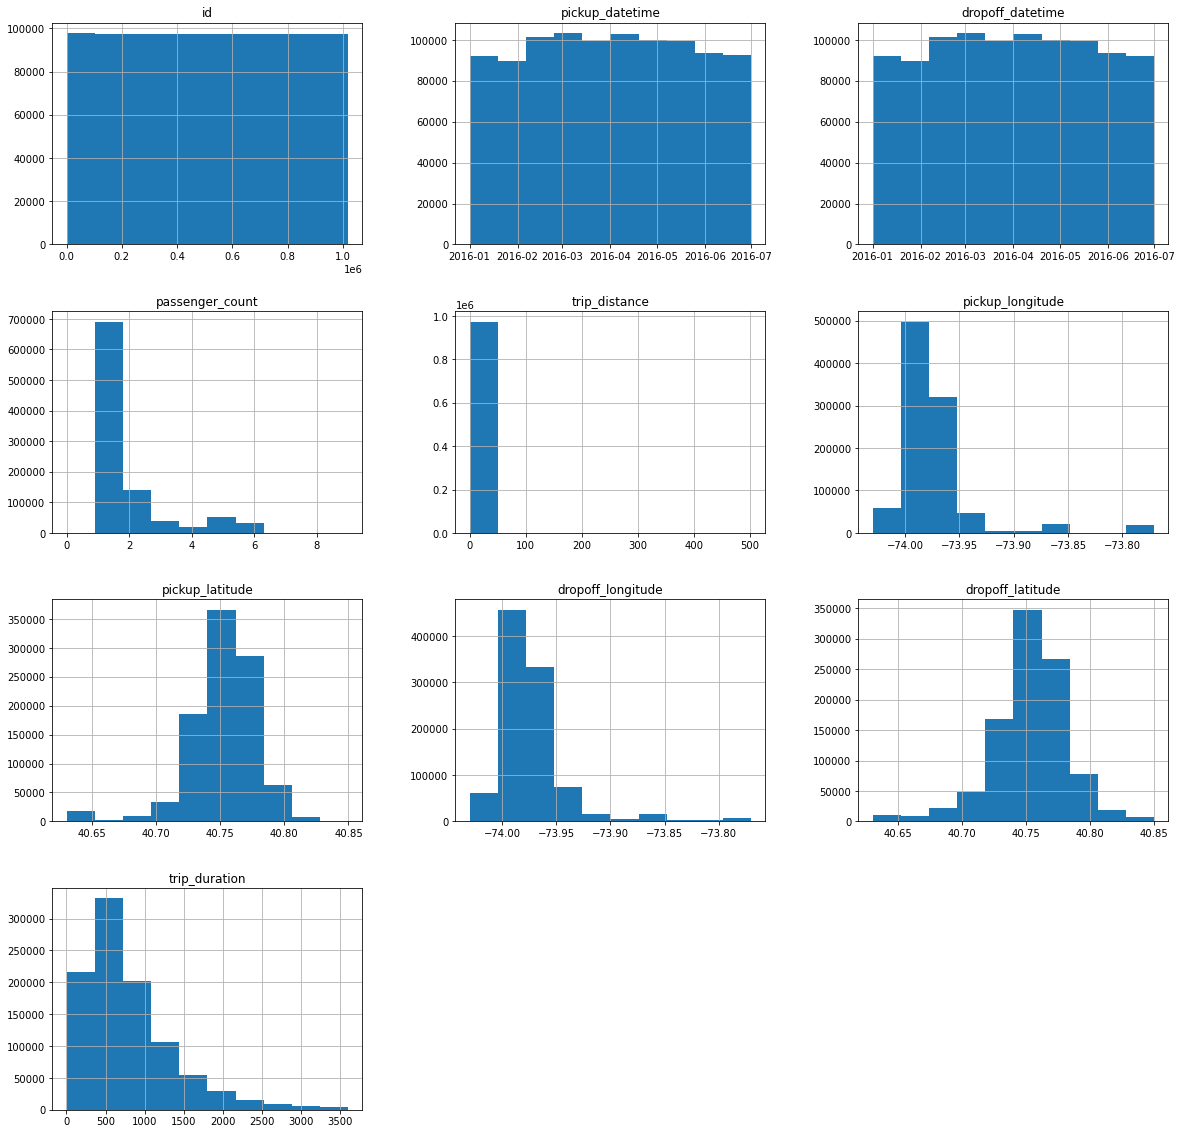

In [15]:
trips.hist(figsize=(20,20))
plt.show()

**Write your answers here:**
- Recall that ``id`` is just a trip identifier, so it is irrelevant for this question.
- ``pickup_datetime`` follows a nearly unitary distribution. This suggests theres pretty much the same demand for taxi rides year round.
- `dropoff_datetime` is the same plot as `pickup_datetime`, this is to be expected since it is notpossible to start a ride and never finish it.
- `passenger_count` is right skewed. This suggests that most taxu rides in NYC are for one or two passengers. Note that the graph goes up to eight passengers. This mens that we have at least one 8 passenger ride in our dataset, and we may have to remove it to clean up our results.
- ``trip_distance`` seem to have some outlier values since we only see a bar at the zero value, we can investigate this further plotting a boxplot. 
- ``pickup_latitude`` and  ``dropoff_latitude`` follow a nearly normal distribution, while  ``pickup_longitude`` and ``dropoff_longitude``  are a bit right skewed.
- ``trip_duration`` is right skewed. Recall the vaues for this variable are in seconds. The graph suggests most trips are ~500 seconds long (~8 min.). Removing outliers for this variable may also be benefitial for model training later on.

E:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


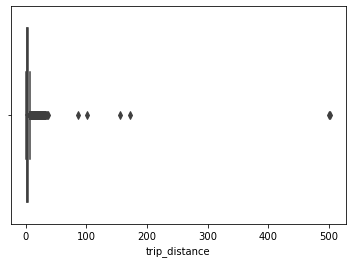

In [16]:
sns.boxplot(trips['trip_distance'])
plt.show()

- We can see there is an extreme outlier in the dataset, we drop investigate it further

In [17]:
trips[trips['trip_distance']>100]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
171143,178815,1,2016-02-04 14:05:10,2016-02-04 14:56:37,1,156.2,-73.979149,40.765499,-73.782806,40.644009,1,3087.0,AR,G
248346,259490,1,2016-02-18 09:48:06,2016-02-18 09:50:27,1,501.4,-73.980087,40.782185,-73.981468,40.778519,2,141.0,I,AV
525084,548884,1,2016-04-07 21:19:03,2016-04-07 22:03:17,3,172.3,-73.783340,40.644176,-73.936028,40.737762,2,2654.0,G,AN
530340,554389,1,2016-04-08 19:19:32,2016-04-08 19:41:33,2,502.8,-73.995461,40.724884,-73.986099,40.762108,1,1321.0,X,AA
828650,867217,1,2016-06-02 21:30:17,2016-06-02 21:36:47,2,101.0,-73.961586,40.800968,-73.950165,40.802193,2,390.0,AH,J


- We can observe that, there are 2 observation>500, and there is a huge gap in the trip duration for them.
- Covering 501.4 distance in 141 sec, is not possible, it is better we can clip these values to 50. 

#### Clipping the outliers of trip distance to 50

In [18]:
trips['trip_distance']=trips['trip_distance'].clip(trips['trip_distance'].min(),50)

E:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


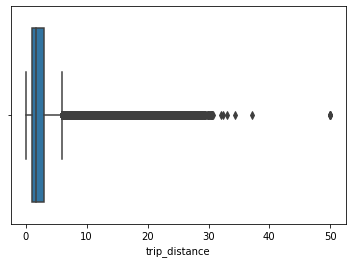

In [19]:
sns.boxplot(trips['trip_distance'])
plt.show()

### Question 2.2 Plotting countplot for Passenger_count (1 Marks)

E:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


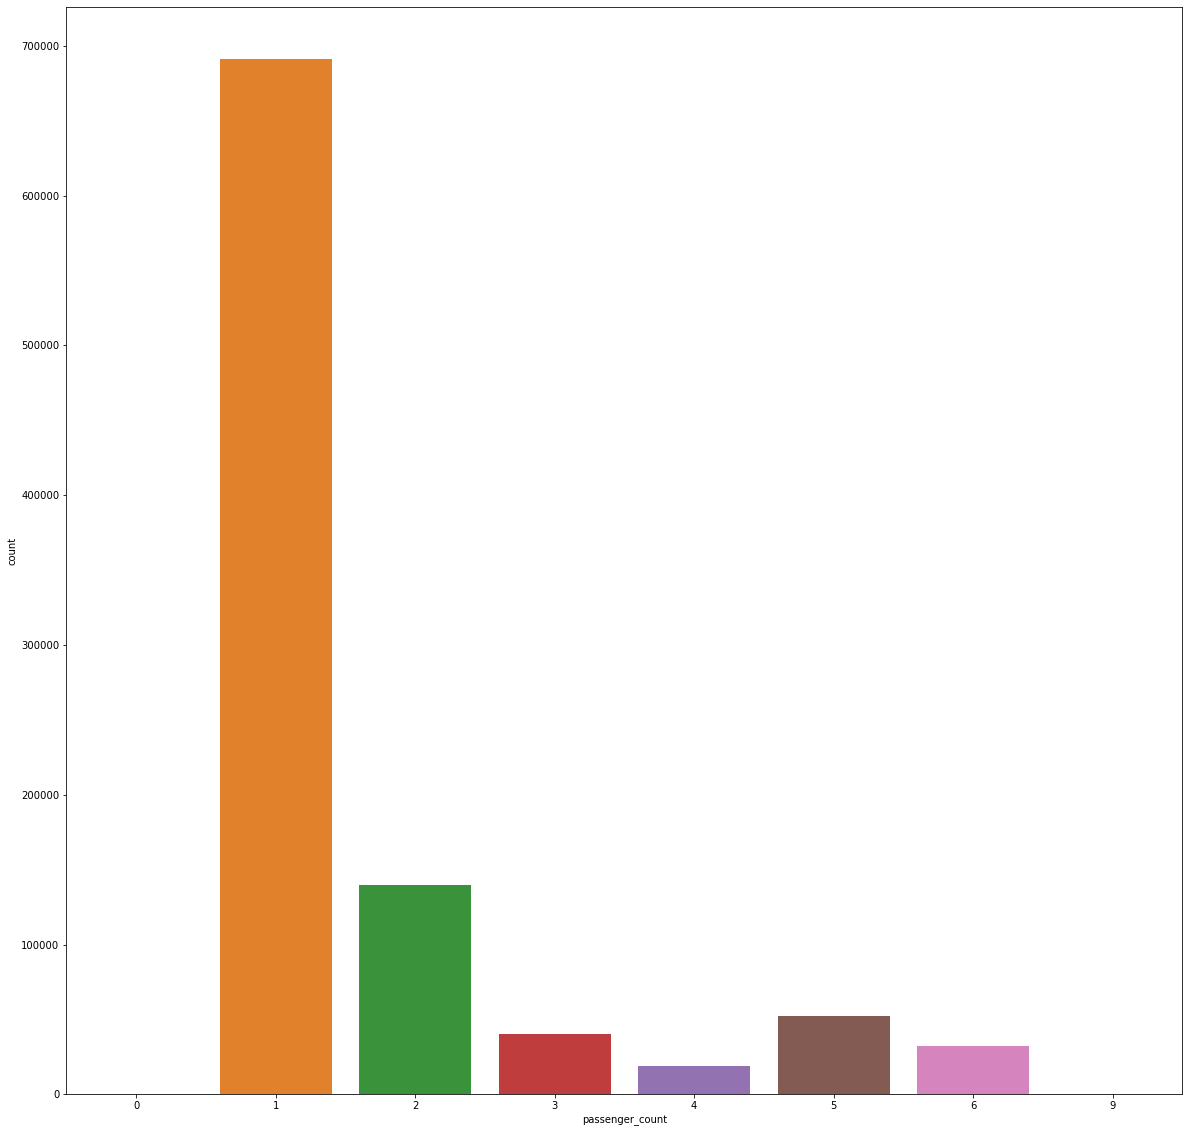

In [20]:
import seaborn as sns
plt.figure(figsize=(20,20))
sns.countplot(trips.passenger_count)
plt.show()

In [21]:
trips.passenger_count.value_counts(normalize=True)

1    0.709334
2    0.143419
5    0.053409
3    0.041140
6    0.033334
4    0.019338
0    0.000025
9    0.000002
Name: passenger_count, dtype: float64

**Write your answers here:**
- The plot above suggests most trips are for one passenger.

### Question 2.3 Plotting countplot for pickup_neighborhood and dropoff_neighborhood (2 Marks)

<AxesSubplot:>

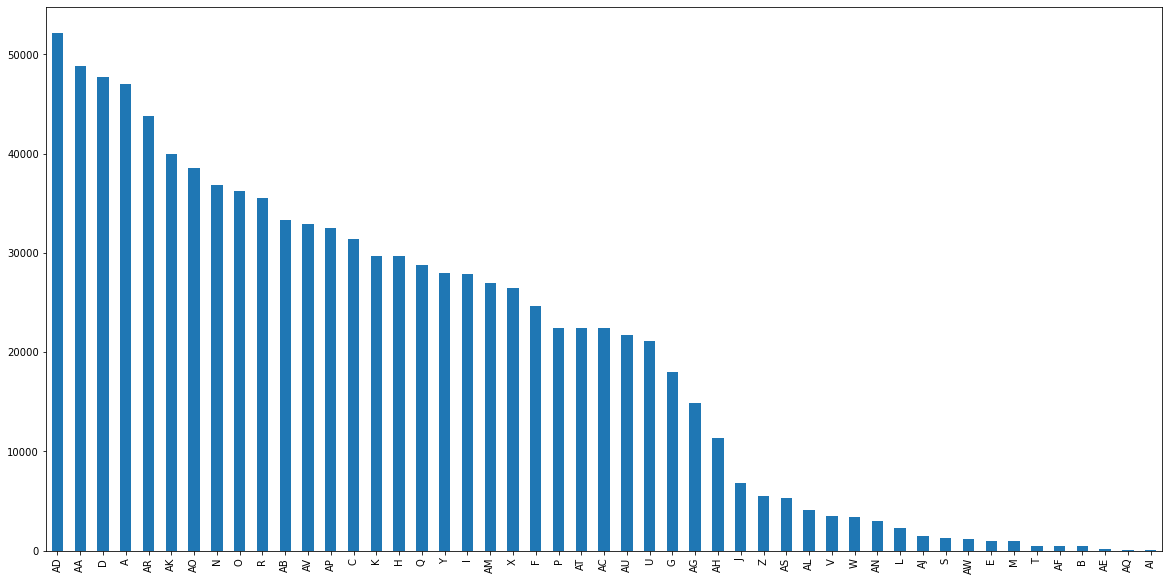

In [22]:
trips.pickup_neighborhood.value_counts().sort_values(ascending=False).plot(kind='bar' ,figsize=(20,10))

<AxesSubplot:>

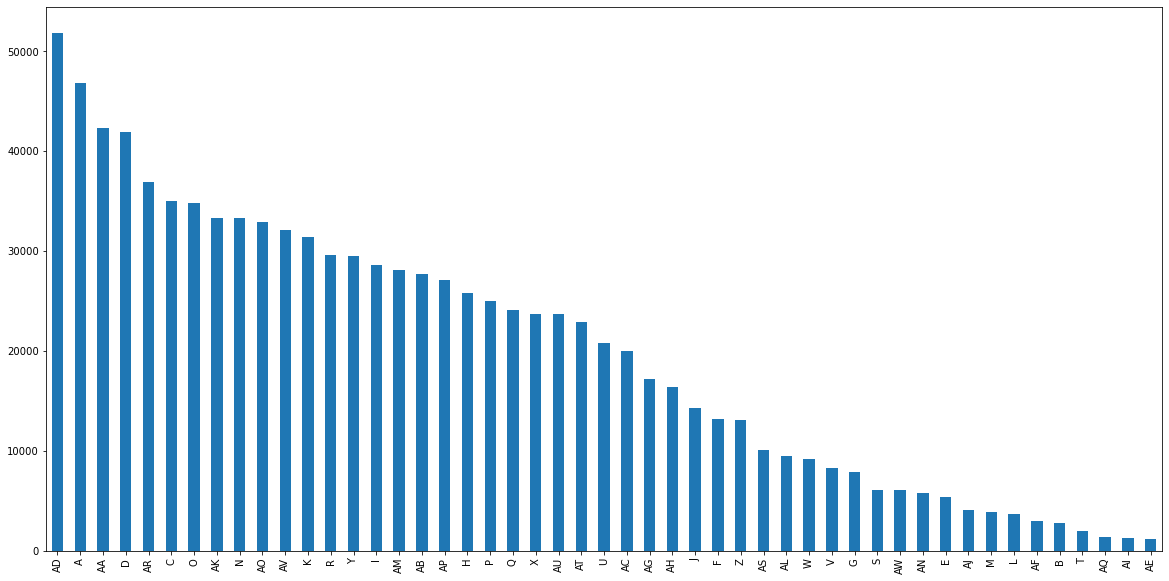

In [23]:
trips.dropoff_neighborhood.value_counts().sort_values(ascending=False).plot(kind='bar' ,figsize=(20,10))

**Write your answers here:**
- Most of the ``pickup_neighborhood`` and ``dropoff_neighborhood`` values are from area AD,A,AA and D; this suggests these are are the most busy areas in the city. 
- Areas like AQ,AI and AE are some areas from where very few number of pickups and dropoff are happening. 

In [24]:
# trips.pickup_neighborhoods.value_counts().sort_values(ascending=False).head()

### Bivariate analysis

#### Plot a scatter plot for trip distance and trip duration

E:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='trip_distance', ylabel='trip_duration'>

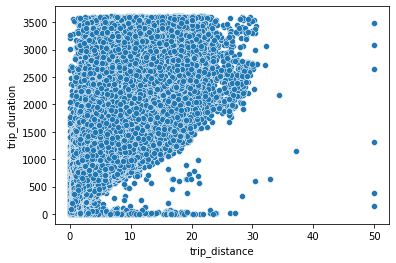

In [25]:
sns.scatterplot(trips['trip_distance'],trips['trip_duration'])

- There is some positive correlation between trip_distance and trip_duration. This is to be expected. However, note that the plot shows pretty much all possible combinations of `trip_duration` and `trip_distance`. At first glance this may suggest ther is not a strong correlation between the two variables; however, this behavior may be due to the fact that we are not taking traffic into account, if we did, the correlation may be clearer.

E:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='passenger_count', ylabel='count'>

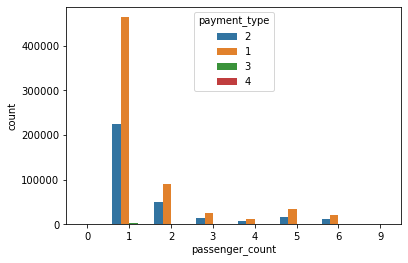

In [26]:
sns.countplot(trips['passenger_count'],hue=trips['payment_type'])

- Recall that the `payment_type` code is:
  - 1= Credit card 
  - 2= Cash 
  - 3= No charge 
  - 4= Dispute 
  - 5= Unknown 
  - 6= Voided
- The plot suggests that pretty much all trips are payed either in cash or card. 
- We expect to see close to no `payment_type` values with the codes 3,4,5 or 6 since they represent extremely rare situations.

### Step 2: Prepare the Data

Lets create entities and relationships. The three entities in this data are 
* trips 
* pickup_neighborhoods
* dropoff_neighborhoods

This data has the following relationships
* pickup_neighborhoods --> trips (one neighborhood can have multiple trips that start in it. This means pickup_neighborhoods is the ``parent_entity`` and trips is the child entity)
* dropoff_neighborhoods --> trips (one neighborhood can have multiple trips that end in it. This means dropoff_neighborhoods is the ``parent_entity`` and trips is the child entity)

In <a <href="https://www.featuretools.com/"><featuretools (automated feature engineering software package)/></a>, we specify the list of entities and relationships as follows: 


### Question 3: Define entities and relationships for the Deep Feature Synthesis (2 Marks)

In [27]:
entities = {
            "trips": (trips, "id", 'pickup_datetime' ),
            "pickup_neighborhoods": (pickup_neighborhoods, "neighborhood_id"),
            "dropoff_neighborhoods": (dropoff_neighborhoods, "neighborhood_id"),
            }

relationships = [
                ("pickup_neighborhoods", "neighborhood_id", "trips", "pickup_neighborhood"),
                ("dropoff_neighborhoods", "neighborhood_id", "trips", "dropoff_neighborhood")
                ]

Next, we specify the cutoff time for each instance of the target_entity, in this case ``trips``.This timestamp represents the last time data can be used for calculating features by DFS. In this scenario, that would be the pickup time because we would like to make the duration prediction using data before the trip starts. 

For the purposes of the case study, we choose to only select trips that started after January 12th, 2016. 

In [28]:
cutoff_time = trips[['id', 'pickup_datetime']]
cutoff_time = cutoff_time[cutoff_time['pickup_datetime'] > "2016-01-12"]
preview(cutoff_time, 10)

,id,pickup_datetime
54031,56311,2016-01-12 00:00:25
667608,698423,2016-05-03 17:59:59
667609,698424,2016-05-03 18:00:52
667610,698425,2016-05-03 18:01:06
667611,698426,2016-05-03 18:01:11
667612,698427,2016-05-03 18:01:12
667613,698428,2016-05-03 18:01:12
667614,698429,2016-05-03 18:01:24
667615,698430,2016-05-03 18:01:36
667616,698431,2016-05-03 18:01:39


### Step 3: Create baseline features using Deep Feature Synthesis

Instead of manually creating features, such as "month of pickup datetime", we can let DFS come up with them automatically. It does this by 
* interpreting the variable types of the columns e.g categorical, numeric and others 
* matching the columns to the primitives that can be applied to their variable types
* creating features based on these matches

**Create transform features using transform primitives**

As we described in the video, features fall into two major categories, ``transform`` and ``aggregate``. In featureools, we can create transform features by specifying ``transform`` primitives. Below we specify a ``transform`` primitive called ``weekend`` and here is what it does:

* It can be applied to any ``datetime`` column in the data. 
* For each entry in the column, it assess if it is a ``weekend`` and returns a boolean. 

In this specific data, there are two ``datetime`` columns ``pickup_datetime`` and ``dropoff_datetime``. The tool automatically creates features using the primitive and these two columns as shown below. 

### Question 4: Creating a baseline model with only 1 transform primitive (10 Marks)

**Question: 4.1 Define transform primitive for weekend and define features using dfs?** 

In [29]:
trans_primitives = [IsWeekend]

#Remove _________ and complete the code
features = ft.dfs(entities=entities,
                  relationships=relationships,
                  target_entity="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=[],
                  ignore_variables={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude"]},
                  features_only=True)

*If you're interested about parameters to DFS such as `ignore_variables`, you can learn more about these parameters [here](https://docs.featuretools.com/generated/featuretools.dfs.html#featuretools.dfs)*
<p>Here are the features created.</p>

In [30]:
print ("Number of features: %d" % len(features))
features

Number of features: 13


[<Feature: vendor_id>,
 <Feature: passenger_count>,
 <Feature: trip_distance>,
 <Feature: payment_type>,
 <Feature: trip_duration>,
 <Feature: pickup_neighborhood>,
 <Feature: dropoff_neighborhood>,
 <Feature: IS_WEEKEND(dropoff_datetime)>,
 <Feature: IS_WEEKEND(pickup_datetime)>,
 <Feature: pickup_neighborhoods.latitude>,
 <Feature: pickup_neighborhoods.longitude>,
 <Feature: dropoff_neighborhoods.latitude>,
 <Feature: dropoff_neighborhoods.longitude>]


Now let's compute the features. 

**Question: 4.2 Compute features and define feature matrix**

In [31]:
def compute_features(features, cutoff_time):
    # shuffle so we don't see encoded features in the front or backs

    np.random.shuffle(features)
    feature_matrix = ft.calculate_feature_matrix(features,
                                                cutoff_time=cutoff_time,
                                                approximate='36d',
                                                verbose=True,entities=entities, relationships=relationships)
    print("Finishing computing...")
    feature_matrix, features = ft.encode_features(feature_matrix, features,
                                                  to_encode=["pickup_neighborhood", "dropoff_neighborhood"],
                                                  include_unknown=False)
    return feature_matrix

In [32]:
feature_matrix1 = compute_features(features, cutoff_time)

Elapsed: 00:05 | Progress: 100%|██████████
Finishing computing...


In [33]:
preview(feature_matrix1, 5).T

id,56311,698423,698424,698425,698426
dropoff_neighborhood = AD,False,True,False,False,False
dropoff_neighborhood = A,False,False,False,False,False
dropoff_neighborhood = AA,False,False,False,False,False
dropoff_neighborhood = D,False,False,False,False,False
dropoff_neighborhood = AR,False,False,False,False,False
dropoff_neighborhood = C,False,False,False,False,False
dropoff_neighborhood = O,False,False,True,False,False
dropoff_neighborhood = N,False,False,False,False,False
dropoff_neighborhood = AK,False,False,False,False,False
dropoff_neighborhood = AO,False,False,False,False,False


In [34]:
feature_matrix1.shape

(920378, 31)

### Build the Model

To build a model, we
* Separate the data into a portion for ``training`` (75% in this case) and a portion for ``testing`` 
* Get the log of the trip duration so that a more linear relationship can be found.
* Train a model using a ``Linear Regression, Decision Tree and Random Forest model``

#### Transforming the duration variable on sqrt and log

(array([  4566.,  35831., 163872., 249551., 225381., 149544.,  80472.,
         38481.,  18054.,   8657.]),
 array([ 1.        ,  6.90499792, 12.80999584, 18.71499376, 24.61999167,
        30.52498959, 36.42998751, 42.33498543, 48.23998335, 54.14498127,
        60.04997918]),
 <BarContainer object of 10 artists>)

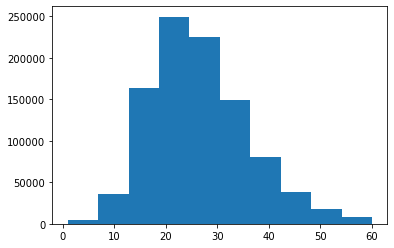

In [35]:
plt.hist(np.sqrt(trips['trip_duration']))

(array([1.81000e+02, 5.97000e+02, 7.44000e+02, 1.43900e+03, 2.86700e+03,
        2.00260e+04, 1.35785e+05, 3.69738e+05, 3.50815e+05, 9.22170e+04]),
 array([0.        , 0.81903544, 1.63807088, 2.45710632, 3.27614176,
        4.0951772 , 4.91421264, 5.73324808, 6.55228352, 7.37131896,
        8.1903544 ]),
 <BarContainer object of 10 artists>)

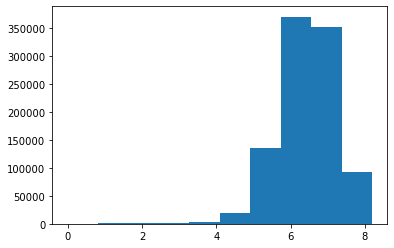

In [36]:
plt.hist(np.log(trips['trip_duration']))

- We can clearly see that the sqrt transformation is giving nearly normal distribution, there for we can choose the sqrt transformation on the dependent(trip_duration) variable.

### Splitting the data into train and test

In [37]:
# separates the whole feature matrix into train data feature matrix, 
# train data labels, and test data feature matrix 
X_train, y_train, X_test, y_test = get_train_test_fm(feature_matrix1,.75)
y_train = np.sqrt(y_train)
y_test = np.sqrt(y_test)

### Defining function for to check the performance of the model. 

In [38]:
#RMSE
def rmse(predictions, targets):
    return np.sqrt(((targets - predictions) ** 2).mean())

# MAE
def mae(predictions, targets):
    return np.mean(np.abs((targets - predictions)))


# Model Performance on test and train data
def model_pref(model, x_train, x_test, y_train,y_test):

    # Insample Prediction
    y_pred_train = model.predict(x_train)
    y_observed_train = y_train

    # Prediction on test data
    y_pred_test = model.predict(x_test)
    y_observed_test = y_test

    print(
        pd.DataFrame(
            {
                "Data": ["Train", "Test"],
                'RSquared':
                    [r2_score(y_observed_train,y_pred_train),
                    r2_score(y_observed_test,y_pred_test )
                    ],
                "RMSE": [
                    rmse(y_pred_train, y_observed_train),
                    rmse(y_pred_test, y_observed_test),
                ],
                "MAE": [
                    mae(y_pred_train, y_observed_train),
                    mae(y_pred_test, y_observed_test),
                ],
            }
        )
    )

#### Question 4.3 Build Linear regression using only weekend transform primitive

In [39]:
#defining the model

lr1=LinearRegression()

#fitting the model
lr1.fit(X_train,y_train)


LinearRegression()

#### Check the performance of the model

In [40]:
model_pref(lr1, X_train, X_test,y_train,y_test)

    Data  RSquared      RMSE       MAE
0  Train  0.576106  6.132169  4.736641
1   Test  0.555831  6.558806  5.024874


**Write your answers here:**
- Model is giving only 0.55 Rsquared, with RSME of 6.55 and MAE of ~5.02.
- Model is slightly overfitting.

#### Question 4.4 Building decision tree using only weekend transform primitive

In [41]:
#define the model
dt=DecisionTreeRegressor()

#fit the model

dt.fit(X_train,y_train)

DecisionTreeRegressor()

#### Check the performance of the model

In [42]:
model_pref(dt, X_train, X_test,y_train,y_test)

    Data  RSquared      RMSE       MAE
0  Train  0.917069  2.712331  1.518055
1   Test  0.597426  6.244153  4.638653


**Write your answers here:**
- The model is overfitting a lot, with train R2 as ~0.92 while test R2 as ~0.59
- This generally happens in decision tree, one solution for this is to Prune the decision tree, let's try pruning and see if the performance improves. 


#### Question 4.5 Building Pruned decision tree using only weekend transform primitive

In [43]:
#define the model

#use max_depth=7
dt_pruned=DecisionTreeRegressor(max_depth=7)

#fit the model
dt_pruned.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=7)

#### Check the performance of the model

In [44]:
model_pref(dt_pruned, X_train, X_test,y_train,y_test)  

    Data  RSquared      RMSE       MAE
0  Train  0.733766  4.859783  3.708634
1   Test  0.704190  5.352503  4.049448


**Write your answers here:**
- The pruned model is performing better that both baseline decision tree and linear regression, with R2 as ~0.70.


#### Question 4.6 Building Random Forest using only weekend transform primitive

In [45]:
#define the model

#using (n_estimators=60,max_depth=7)

rf=RandomForestRegressor(n_estimators=60,max_depth=7)

In [46]:
#fit the model

rf.fit(X_train,y_train)

RandomForestRegressor(max_depth=7, n_estimators=60)

#### Check the performance of the model

In [47]:
model_pref(rf, X_train, X_test,y_train,y_test)

    Data  RSquared      RMSE       MAE
0  Train  0.738265  4.818549  3.676261
1   Test  0.708235  5.315778  4.019578


**Write your answers here:**
- The score for the model with only 1 transform primitive is ~71%. 
- This model is performing slightly better than pruned decision tree model.
- Model is still overfitting.


### Step 4: Adding more Transform Primitives and creating new model

* Add ``Minute``, ``Hour``, ``Month``, ``Weekday`` , etc primitives
* All these transform primitives apply to ``datetime`` columns

### Question 5: Create models with more transform primitives (10 Marks)

**Question 5.1 Define more transform primitives and define features using dfs?**

In [48]:
trans_primitives = [Minute, Hour, Day, Month, Weekday, IsWeekend]

features = ft.dfs(entities=entities,
                  relationships=relationships,
                  target_entity="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=[],
                  ignore_variables={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude"]},
                  features_only=True)

In [49]:
print ("Number of features: %d" % len(features))
features

Number of features: 23


[<Feature: vendor_id>,
 <Feature: passenger_count>,
 <Feature: trip_distance>,
 <Feature: payment_type>,
 <Feature: trip_duration>,
 <Feature: pickup_neighborhood>,
 <Feature: dropoff_neighborhood>,
 <Feature: DAY(dropoff_datetime)>,
 <Feature: DAY(pickup_datetime)>,
 <Feature: HOUR(dropoff_datetime)>,
 <Feature: HOUR(pickup_datetime)>,
 <Feature: IS_WEEKEND(dropoff_datetime)>,
 <Feature: IS_WEEKEND(pickup_datetime)>,
 <Feature: MINUTE(dropoff_datetime)>,
 <Feature: MINUTE(pickup_datetime)>,
 <Feature: MONTH(dropoff_datetime)>,
 <Feature: MONTH(pickup_datetime)>,
 <Feature: WEEKDAY(dropoff_datetime)>,
 <Feature: WEEKDAY(pickup_datetime)>,
 <Feature: pickup_neighborhoods.latitude>,
 <Feature: pickup_neighborhoods.longitude>,
 <Feature: dropoff_neighborhoods.latitude>,
 <Feature: dropoff_neighborhoods.longitude>]

Now let's compute the features. 

**Question: 5.2 Compute features and define feature matrix**

In [50]:
feature_matrix2 = compute_features(features, cutoff_time)

Elapsed: 00:06 | Progress: 100%|██████████
Finishing computing...


In [51]:
feature_matrix2.shape

(920378, 41)

In [52]:
feature_matrix2.head().T

id,56311,56312,56313,56314,56315
WEEKDAY(pickup_datetime),1,1,1,1,1
trip_duration,645.0,1270.0,207.0,214.0,570.0
MINUTE(pickup_datetime),0,2,2,2,3
DAY(dropoff_datetime),12,12,12,12,12
payment_type,1,2,1,2,1
IS_WEEKEND(dropoff_datetime),False,False,False,False,False
pickup_neighborhoods.latitude,40.720245,40.646194,40.818445,40.729652,40.793597
DAY(pickup_datetime),12,12,12,12,12
dropoff_neighborhood = AD,False,False,False,False,False
dropoff_neighborhood = A,False,False,False,False,False


### Build the new models more transform features

In [53]:
# separates the whole feature matrix into train data feature matrix,
# train data labels, and test data feature matrix 
X_train2, y_train2, X_test2, y_test2 = get_train_test_fm(feature_matrix2,.75)
y_train2 = np.sqrt(y_train2)
y_test2 = np.sqrt(y_test2)

#### Question 5.3 Building Linear regression using more transform primitive

In [54]:
#defining the model

lr2=LinearRegression()

#fitting the model
lr2.fit(X_train2,y_train2)


LinearRegression()

#### Check the performance of the model

In [55]:
model_pref(lr2, X_train2, X_test2,y_train2,y_test2)  

    Data  RSquared      RMSE       MAE
0  Train  0.623501  5.779195  4.273127
1   Test  0.623651  6.037346  4.537582


**Write your answers here:**
- Model is giving ~0.62 Rsquared, with RSME of ~6.04 and MAE of ~4.54.
- Model performance has improved from the last model by adding more transform primitives
- Model is not overfitting, thus giving generalized results.

#### Question 5.4 Building Decision tree using more transform primitive

In [56]:
#define the model
dt2=DecisionTreeRegressor()

#fit the model

dt2.fit(X_train2,y_train2)

DecisionTreeRegressor()

#### Check the performance of the model

In [57]:
model_pref(dt2, X_train2, X_test2,y_train2,y_test2)  

    Data  RSquared      RMSE       MAE
0  Train  1.000000  0.001479  0.000004
1   Test  0.713607  5.266615  3.789094


**Write your answers here:**
- The model is overfitting a lot, with train R2 as 1 while test R2 as ~0.71.
- This generally happens in decision tree, one solution for this is to Prune the decision tree, let's try pruning and see if the performance improves.

#### Question 5.5 Building Pruned Decision tree using more transform primitive

In [58]:
#define the model

#use max_depth=7
dt_pruned2=DecisionTreeRegressor(max_depth=7)

#fit the model
dt_pruned2.fit(X_train2,y_train2)

DecisionTreeRegressor(max_depth=7)

#### Check the performance of the model

In [59]:
model_pref(dt_pruned2, X_train2, X_test2,y_train2,y_test2) 

    Data  RSquared      RMSE       MAE
0  Train  0.768105  4.535566  3.423759
1   Test  0.745845  4.961350  3.698053


**Write your answers here:**
- Model is giving ~0.75 Rsquared, with RSME of ~4.96 and MAE of ~3.70.
- Model performance has improved by adding more transform features. 
- Model is slightly overfitting.

#### Question 5.6 Building Random Forest using more transform primitive

In [60]:
#fit the model

#using (n_estimators=60,max_depth=7)

rf2=RandomForestRegressor(n_estimators=60,max_depth=7)

#fit the model

rf2.fit(X_train2,y_train2)

RandomForestRegressor(max_depth=7, n_estimators=60)

#### Check the performance of the model

In [61]:
model_pref(rf2, X_train2, X_test2,y_train2,y_test2)

    Data  RSquared      RMSE       MAE
0  Train  0.774642  4.471179  3.366930
1   Test  0.751791  4.902971  3.645133


**Write your answers here:**
- The score for the model with more transform primitive is ~75%. 
- As compared to previous model, the score has improved.

**Question: 5.7 Comment on how the modeling accuracy differs when including more transform features.**

**Write your answers here:**
- With the current parameters, the general behavior we observe when buiding our models with mode transform features, is the performance on the test set increasing by ~6.4% in average. This means that including more transfom features makes a big improvement and it was worth testing.

### Step 5: Add Aggregation Primitives

Now let's add aggregation primitives. These primitives will generate features for the parent entities ``pickup_neighborhoods``, and ``dropoff_neighborhood`` and then add them to the trips entity, which is the entity for which we are trying to make prediction.

### Question 6: Create a Models with transform and aggregate primitive. (10 Marks)
**6.1 Define more transform and aggregate primitive and define features using dfs?**

In [62]:
trans_primitives = [Minute, Hour, Day, Month, Weekday, IsWeekend]
aggregation_primitives = [Count, Sum, Mean, Median, Std, Max, Min]

features = ft.dfs(entities=entities,
                  relationships=relationships,
                  target_entity="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=aggregation_primitives,
                  ignore_variables={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude"]},
                  features_only=True)

In [63]:
print ("Number of features: %d" % len(features))
features

Number of features: 61


[<Feature: vendor_id>,
 <Feature: passenger_count>,
 <Feature: trip_distance>,
 <Feature: payment_type>,
 <Feature: trip_duration>,
 <Feature: pickup_neighborhood>,
 <Feature: dropoff_neighborhood>,
 <Feature: DAY(dropoff_datetime)>,
 <Feature: DAY(pickup_datetime)>,
 <Feature: HOUR(dropoff_datetime)>,
 <Feature: HOUR(pickup_datetime)>,
 <Feature: IS_WEEKEND(dropoff_datetime)>,
 <Feature: IS_WEEKEND(pickup_datetime)>,
 <Feature: MINUTE(dropoff_datetime)>,
 <Feature: MINUTE(pickup_datetime)>,
 <Feature: MONTH(dropoff_datetime)>,
 <Feature: MONTH(pickup_datetime)>,
 <Feature: WEEKDAY(dropoff_datetime)>,
 <Feature: WEEKDAY(pickup_datetime)>,
 <Feature: pickup_neighborhoods.latitude>,
 <Feature: pickup_neighborhoods.longitude>,
 <Feature: dropoff_neighborhoods.latitude>,
 <Feature: dropoff_neighborhoods.longitude>,
 <Feature: pickup_neighborhoods.COUNT(trips)>,
 <Feature: pickup_neighborhoods.MAX(trips.passenger_count)>,
 <Feature: pickup_neighborhoods.MAX(trips.trip_distance)>,
 <Feature:

**Question: 6.2 Compute features and define feature matrix**

In [64]:
feature_matrix3 = compute_features(features, cutoff_time)

Elapsed: 00:13 | Progress: 100%|██████████
Finishing computing...


In [65]:
feature_matrix3.head()

,MINUTE(dropoff_datetime),dropoff_neighborhoods.MEDIAN(trips.passenger_count),dropoff_neighborhood = AD,dropoff_neighborhood = A,dropoff_neighborhood = AA,dropoff_neighborhood = D,dropoff_neighborhood = AR,dropoff_neighborhood = C,dropoff_neighborhood = O,dropoff_neighborhood = N,...,pickup_neighborhood = D,pickup_neighborhood = A,pickup_neighborhood = AR,pickup_neighborhood = AK,pickup_neighborhood = AO,pickup_neighborhood = N,pickup_neighborhood = O,pickup_neighborhood = R,pickup_neighborhoods.SUM(trips.trip_distance),pickup_neighborhoods.MEAN(trips.trip_distance)
id,,,,,,,,,,,,,,,,,,,,,
56311,11,1.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,3904.70,3.008243
56312,23,1.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,19468.13,15.574504
56313,5,1.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,625.38,2.868716
56314,6,1.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,3891.78,2.285250
56315,13,1.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,2524.92,2.147041


### Build the new models more transform and aggregate features

In [66]:
# separates the whole feature matrix into train data feature matrix,
# train data labels, and test data feature matrix 
X_train3, y_train3, X_test3, y_test3 = get_train_test_fm(feature_matrix3,.75)
y_train3 = np.sqrt(y_train3)
y_test3 = np.sqrt(y_test3)

#### Question 6.3 Building  Linear regression model with transform and aggregate primitive.

In [67]:
#defining the model

lr3=LinearRegression()

#fitting the model
lr3.fit(X_train3,y_train3)


LinearRegression()

#### Check the performance of the model

In [69]:
model_pref(lr3, X_train3, X_test3,y_train3,y_test3)   

    Data  RSquared      RMSE       MAE
0  Train  0.643423  5.624220  4.134927
1   Test  0.631697  5.972457  4.464424


**Write your answers here:**
- Model is giving ~0.63 Rsquared, with RSME of ~5.97 and MAE of ~4.46.
- Model is not overfitting, and giving generalized results. 

#### Question 6.4 Building  Decision tree with transform and aggregate primitive.

In [70]:
#define the model
dt3=DecisionTreeRegressor()

#fit the model

dt3.fit(X_train3,y_train3)

DecisionTreeRegressor()

#### Check the performance of the model

In [71]:
model_pref(dt3, X_train3, X_test3,y_train3,y_test3) 

    Data  RSquared      RMSE       MAE
0  Train  1.000000  0.001479  0.000004
1   Test  0.648706  5.832915  4.190501


**Write your answers here:**
- The model is overfitting a lot, with train R2 as 1 while test R2 as ~0.65
- This generally happens in decision tree, one solution for this is to Prune the decision tree, let's try pruning and see if the performance improves.

#### Question 6.5 Building  Pruned Decision tree with transform and aggregate primitive.

In [72]:
#define the model

#use max_depth=7
dt_pruned3=DecisionTreeRegressor(max_depth=7)

#fit the model
dt_pruned3.fit(X_train3,y_train3)

DecisionTreeRegressor(max_depth=7)

#### Check the performance of the model

In [73]:
model_pref(dt_pruned3, X_train3, X_test3,y_train3,y_test3)  

    Data  RSquared      RMSE       MAE
0  Train  0.769212  4.524722  3.418452
1   Test  0.745722  4.962549  3.696122


**Write your answers here:**
- Model is giving ~0.75 Rsquared, with RSME of ~4.9 and MAE of ~3.7.
- The model performance has not improved by adding aggregate primitives.
- Model is slightly overfitting, but is giving acceptable generalized results for this use-case.

#### Question 6.6 Building  Random Forest with transform and aggregate primitive.

In [75]:
#fit the model

#using (n_estimators=60,max_depth=7)

rf3=RandomForestRegressor(n_estimators=60,max_depth=7)

#fit the model

rf3.fit(X_train3,y_train3)

RandomForestRegressor(max_depth=7, n_estimators=60)

#### Check the performance of the model

In [76]:
model_pref(rf3, X_train3, X_test3,y_train3,y_test3)  

    Data  RSquared      RMSE       MAE
0  Train  0.776521  4.452501  3.354643
1   Test  0.753109  4.889936  3.633362


**Write your answers here:**
- The model Performance has marginaly improved from ~0.752 to ~0.753 by the addition of transform and aggregation features.
- The modeling score has not improved much after adding aggregate transforms, and the training time was increased by a significant amount, implying that adding more features is not always very effective. 

**Question 6.7 How do these aggregate transforms impact performance? How do they impact training time?**

**Write your answers here:**
- Aggregate Transforms caused a marginal improvent in performance.
- Aggregate Transforms greately increased training time compared to previous models.

#### Based on the above 3 models, we can make predictions using our model2, as it is giving almost same accuracy as model3 and also the training time is not that large as compared to model3

In [77]:
y_pred = rf2.predict(X_test2)
y_pred = y_pred**2 # undo the sqrt we took earlier
y_pred[5:]

array([ 528.98474395,  215.79232445,  663.81910876, ...,  182.07380292,
       1028.99455389, 1759.33222947])

### Question 7: What are some important features based on model2 and how can they affect the duration of the rides? (3 Marks)

In [80]:
feature_importances(rf2, feature_matrix2.drop(['trip_duration'],axis=1).columns, n=10)

1: Feature: trip_distance, 0.910
2: Feature: HOUR(dropoff_datetime), 0.036
3: Feature: HOUR(pickup_datetime), 0.019
4: Feature: dropoff_neighborhoods.latitude, 0.016
5: Feature: pickup_neighborhoods.longitude, 0.003
6: Feature: WEEKDAY(dropoff_datetime), 0.003
7: Feature: IS_WEEKEND(dropoff_datetime), 0.003
8: Feature: WEEKDAY(pickup_datetime), 0.003
9: Feature: vendor_id, 0.002
10: Feature: IS_WEEKEND(pickup_datetime), 0.002


**Write your answers here:**
- `trip_distance` is the most influential variable by far, having a 91% weight in the duration of the ride.
- `dropoff_datetime` and `pickup_datetime` can be translated to "time of day". Their little influence on the duration of the ride may suggest there is little variation in traffic density throught the day in NYC.
- `dropoff_neighborhoods.latitude` influence on the duration of the rides may suggest there is one side of the city slightly more crowded at any given time.
- The rest of the features seem to be neglectable for our current objective with the given dataset.
- It is worth mentioning that (perhaps counterintuitively), the day of the week is pretty much irrelevant. Suggesting a consistent traffic flow in NYC throught the week.